# Q-Learning on Taxi-v3 (Gymnasium)

In this notebook, we train a **Q-learning** agent to solve the classic **Taxi-v3** environment from Gymnasium.  
The task takes place on a 5×5 grid, where a taxi must **pick up** a passenger at one location and **drop off** the passenger at a designated destination.

---

### Objective
Learn an optimal **policy** that maximizes expected rewards under the Taxi-v3 rules:
- **−1** per step (to encourage efficiency)  
- **−10** for illegal pickup or drop-off actions  
- **+20** for successfully dropping off the passenger at the goal

---

### What You’ll Do
1. Initialize a **Q-table** for all state–action pairs (500 states × 6 actions).  
2. Train the agent using **ε-greedy exploration** and the **Q-learning update rule**.  
3. Track and visualize **learning progress** over episodes.  
4. Evaluate the **greedy policy** (no exploration) to measure performance.  
5. Decode and inspect the learned **state–action behavior** to understand the strategy.


## Environment at a Glance

**Taxi-v3** is a discrete MDP on a 5×5 grid. The taxi must **pick up** a passenger at one of four landmark locations and **drop off** at a specified destination.

- **Observation space:** 500 discrete states  
  - State encodes: **taxi row (5)** × **taxi column (5)** × **passenger location (5: R/G/B/Y or in taxi)** × **destination (4: R/G/B/Y)** = 500
- **Action space (6):**

  0. South  
  1. North  
  2. East  
  3. West  
  4. Pickup  
  5. Dropoff
- **Rewards:**
  - **+20** for a successful dropoff at the correct destination  
  - **−1** per time step (encourages efficiency)  
  - **−10** for an illegal **Pickup/Dropoff** (e.g., wrong location or no passenger)
- **Episode termination:** when the passenger is dropped at the destination (success) or when the episode times out (env’s max steps).
- **Dynamics:** deterministic moves on the grid (walls block motion between some cells).

> Tip: You can `env.render()` (text mode) during evaluation to visualize the taxi (`T`), passenger source, and destination cells.


In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Inline plotting
%matplotlib inline

# Optional: quick version check
print("Gymnasium:", gym.__version__)
print("NumPy:", np.__version__)


Gymnasium: 1.2.1
NumPy: 2.2.6


In [3]:
# Create Environment & Inspect Spaces
env = gym.make("Taxi-v3")
state, info = env.reset(seed=SEED)

n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"Initial state: {state}")
print(f"Number of states: {n_states}")
print(f"Number of actions: {n_actions}")


Initial state: 386
Number of states: 500
Number of actions: 6


## Q-Learning Refresher

**Q-learning** is an off-policy, model-free reinforcement learning algorithm used to learn the value of taking a specific action in a given state.

At each step, the agent updates its estimate of the Q-value using the **Bellman equation**:


The agent balances **exploration** and **exploitation** via an **ε-greedy policy**:
- With probability **ε**, choose a random action (explore).  
- With probability **1 − ε**, choose the action with the highest Q-value (exploit).

Over time, as ε decays, the policy becomes greedier, converging toward optimal behavior.


In [ ]:
# Q-Table & Hyperparameters

# Initialize the Q-table with zeros
Q = np.zeros((n_states, n_actions))

# Hyperparameters
alpha = 0.1 # Learning rate
gamma = 0.99 # Discount factor
epsilon = 1.0 # Exploration rate (start fully random)
epsilon_min = 0.05 # Minimum exploration rate
epsilon_decay = 0.995
episodes = 5000 # Change episodes as needed
max_steps_per_episode = 100

print("Q-table shape:", Q.shape)


Q-table shape: (500, 6)


In [5]:
# Helper Utilities
def moving_average(x, window=100):
    """Compute moving average for smoothing rewards."""
    if len(x) < window:
        return np.array(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

def epsilon_greedy_action(state, epsilon):
    """Select an action using the epsilon-greedy strategy."""
    if np.random.random() < epsilon:
        return np.random.randint(n_actions) # Explore
    else:
        return np.argmax(Q[state]) # Exploit


In [ ]:
# Training Loop
rewards_per_episode = []

for episode in range(episodes):
    state, info = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # Q-learning update rule
        best_next_action = np.argmax(Q[next_state])
        Q[state, action] = Q[state, action] + alpha * (
            reward + gamma * Q[next_state, best_next_action] - Q[state, action]
        )

        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{episodes}, epsilon={epsilon:.3f}")


Episode 500/5000, epsilon=0.082
Episode 1000/5000, epsilon=0.050
Episode 1500/5000, epsilon=0.050
Episode 2000/5000, epsilon=0.050
Episode 2500/5000, epsilon=0.050
Episode 3000/5000, epsilon=0.050
Episode 3500/5000, epsilon=0.050
Episode 4000/5000, epsilon=0.050
Episode 4500/5000, epsilon=0.050
Episode 5000/5000, epsilon=0.050


## Training Notes & Pitfalls

A few things to keep in mind while training the Taxi-v3 Q-learning agent:

- **Sparse Rewards:** The agent only receives a large positive reward (+20) at the end of a successful episode, so early in training it may seem like it’s not learning much.  
- **Exploration Decay:** If ε decays too quickly, the agent may stop exploring before finding good trajectories. If it decays too slowly, convergence will be slower.  
- **Learning Rate (α):** Too high, and learning becomes unstable; too low, and convergence is painfully slow.  
- **Discount Factor (γ):** Controls how much the agent values future rewards. A value close to 1 encourages longer-term planning.  
- **Illegal Actions:** Picking up or dropping off at the wrong place gives −10. The agent must learn to avoid these.  
- **Episode Length:** Taxi-v3 can require many steps per episode before success. Make sure `max_steps_per_episode` is sufficient for meaningful exploration.

> Early learning curves will fluctuate heavily. As Q-values stabilize, the moving average of rewards should gradually trend upward.


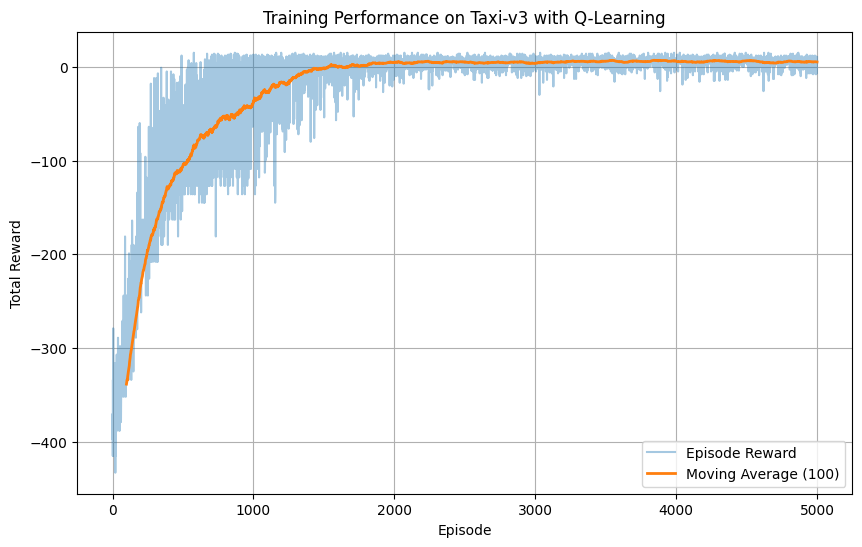

In [7]:
# Learning Curves
# Compute moving average of rewards for smoothing
window_size = 100
smoothed_rewards = moving_average(rewards_per_episode, window_size)

# Plot learning progress
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label="Episode Reward", alpha=0.4)
plt.plot(range(window_size - 1, len(smoothed_rewards) + window_size - 1),
         smoothed_rewards, label=f"Moving Average ({window_size})", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance on Taxi-v3 with Q-Learning")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate Greedy Policy (No Exploration)
eval_episodes = 100
total_eval_rewards = []

for episode in range(eval_episodes):
    state, info = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        # Always exploit (no randomness)
        action = np.argmax(Q[state])
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        state = next_state

        if terminated or truncated:
            break

    total_eval_rewards.append(episode_reward)

avg_reward = np.mean(total_eval_rewards)
success_rate = np.mean([r > 0 for r in total_eval_rewards])

print(f"Average reward over {eval_episodes} evaluation episodes: {avg_reward:.2f}")
print(f"Success rate: {success_rate * 100:.1f}%")


Average reward over 100 evaluation episodes: 8.05
Success rate: 100.0%


## Visualizing Taxi States

Each **Taxi-v3** state is represented as a single integer (0–499) that encodes four pieces of information:

1. **Taxi row** - where the taxi is on the grid (5 possible values)  
2. **Taxi column** - horizontal position on the grid (5 possible values)  
3. **Passenger location** - one of four landmarks (`R`, `G`, `Y`, `B`) or already in the taxi (5 values)  
4. **Destination** - one of the four landmark locations (4 values)

That gives a total of 5 * 5 * 5 * 4 = 500 unique states.

You can **visualize** the environment using:
```python
env.render()


In [10]:
# Decode & Print a Trajectory (Greedy Policy)

def run_greedy_episode(render=True, max_steps=20):
    """Run one greedy (epsilon=0) episode and optionally render each step."""
    state, info = env.reset()
    total_reward = 0

    print("Starting Greedy Episode:")
    print("-" * 40)

    for step in range(max_steps):
        action = np.argmax(Q[state])
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        if render:
            env.render()
            print(f"Step {step + 1}: Action = {action}, Reward = {reward}")
            print("-" * 40)

        state = next_state

        if terminated or truncated:
            print("Episode finished!")
            break

    print(f"Total Reward: {total_reward}")
    return total_reward

# Run and visualize one trajectory
run_greedy_episode()


Starting Greedy Episode:
----------------------------------------
Step 1: Action = 0, Reward = -1
----------------------------------------
Step 2: Action = 0, Reward = -1
----------------------------------------
Step 3: Action = 2, Reward = -1
----------------------------------------
Step 4: Action = 2, Reward = -1
----------------------------------------
Step 5: Action = 0, Reward = -1
----------------------------------------
Step 6: Action = 0, Reward = -1
----------------------------------------
Step 7: Action = 4, Reward = -1
----------------------------------------
Step 8: Action = 1, Reward = -1
----------------------------------------
Step 9: Action = 2, Reward = -1
----------------------------------------
Step 10: Action = 1, Reward = -1
----------------------------------------
Step 11: Action = 1, Reward = -1
----------------------------------------
Step 12: Action = 1, Reward = -1
----------------------------------------
Step 13: Action = 5, Reward = 20
----------------------

8

## Visualize the Best Policy

This section renders a **video** of a greedy rollout using the **best-performing Q-table**:

Greedy rollout return: 8


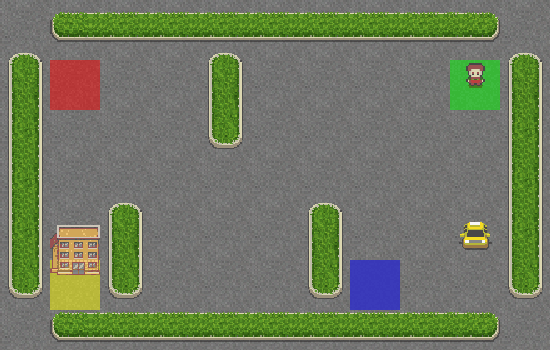

In [ ]:
# Minimal greedy rollout video (uses the existing trained Q table `Q`)
import imageio.v2 as imageio
from IPython.display import Image, display

# check if Q-table and seed are set already
assert 'Q' in globals(), "Q-table not found. Train the agent first."
assert 'SEED' in globals(), "SEED not found. Ensure the setup cell was run."

def record_greedy_gif(Q, max_steps=200, seed=SEED, path="taxi_greedy.gif", fps=4):
    env = gym.make("Taxi-v3", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    frames = []
    total_reward = 0

    for _ in range(max_steps):
        frames.append(env.render())  # capture before action for smoother playback
        action = int(np.argmax(Q[state]))
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            frames.append(env.render())
            break

    env.close()
    imageio.mimsave(path, frames, fps=fps)
    return path, total_reward

gif_path, ret = record_greedy_gif(Q)
print(f"Greedy rollout return: {ret}")
display(Image(filename=gif_path))


## Learned Policy Peek

Once training is complete, the **Q-table** represents the learned value of every state–action pair.  
From it, we can extract a **greedy policy**.

This gives the agent’s preferred action for each of the 500 discrete states.

Keep in mind:
- Not all states are visited equally — many combinations of taxi position, passenger, and destination are rare.  
- The Q-values for unvisited states will remain near zero, so their actions may appear arbitrary.  
- The most meaningful policy insights come from states that occur frequently during successful episodes.

>  You can visualize or analyze a subset of the learned policy — for example, pick a fixed destination and passenger location, and plot which actions the agent prefers across the 5×5 grid.


In [11]:
# Save / Load Q-Table and Hyperparameters

import json
from pathlib import Path

# Directory to save artifacts
save_dir = Path("artifacts")
save_dir.mkdir(exist_ok=True)

# Save Q-table
np.save(save_dir / "taxi_q_table.npy", Q)

# Save training configuration
config = {
    "alpha": alpha,
    "gamma": gamma,
    "epsilon_min": epsilon_min,
    "epsilon_decay": epsilon_decay,
    "episodes": episodes,
    "max_steps_per_episode": max_steps_per_episode,
}
with open(save_dir / "taxi_config.json", "w") as f:
    json.dump(config, f, indent=4)

print("Q-table and config saved to 'artifacts/' directory.")

# Example: to load later
# Q_loaded = np.load("artifacts/taxi_q_table.npy")
# with open("artifacts/taxi_config.json") as f:
#     config_loaded = json.load(f)


Q-table and config saved to 'artifacts/' directory.


## Hyperparameter Tips

Choosing the right hyperparameters can dramatically affect training stability and speed:

- **Learning rate (α):**  
  Controls how strongly new information overrides old estimates.  
  Typical range: `0.1 – 0.5`. Too high -> unstable; too low -> slow convergence.

- **Discount factor (γ):**  
  Determines how far into the future the agent looks for rewards.  
  Typical range: `0.9 – 0.99`. A high value encourages longer-term planning.

- **Exploration rate (ε) and decay:**  
  - Start high (1.0) for early exploration.  
  - Gradually decay toward a small floor (0.01–0.1).  
  - If ε decays too quickly, the agent might stop exploring before discovering optimal paths.

- **Episodes:**  
  More episodes = better convergence, but longer training.  
  Start with `5,000–10,000` and adjust based on reward trends.

- **Max steps per episode:**  
  Should be large enough for the taxi to complete the task — 100–200 steps usually works well.

> If your learning curve plateaus at low reward values, try increasing `ε_decay` (slower decay) or `α` slightly to encourage continued exploration and learning.


α=0.1, ε_decay=0.999 -> Avg Eval Reward: 8.20
α=0.1, ε_decay=0.997 -> Avg Eval Reward: 3.79
α=0.1, ε_decay=0.995 -> Avg Eval Reward: 6.10
α=0.1, ε_decay=0.99 -> Avg Eval Reward: -0.60
α=0.2, ε_decay=0.999 -> Avg Eval Reward: 7.98
α=0.2, ε_decay=0.997 -> Avg Eval Reward: 7.87
α=0.2, ε_decay=0.995 -> Avg Eval Reward: 7.65
α=0.2, ε_decay=0.99 -> Avg Eval Reward: 7.86
α=0.4, ε_decay=0.999 -> Avg Eval Reward: 8.19
α=0.4, ε_decay=0.997 -> Avg Eval Reward: 7.98
α=0.4, ε_decay=0.995 -> Avg Eval Reward: 7.61
α=0.4, ε_decay=0.99 -> Avg Eval Reward: 7.69


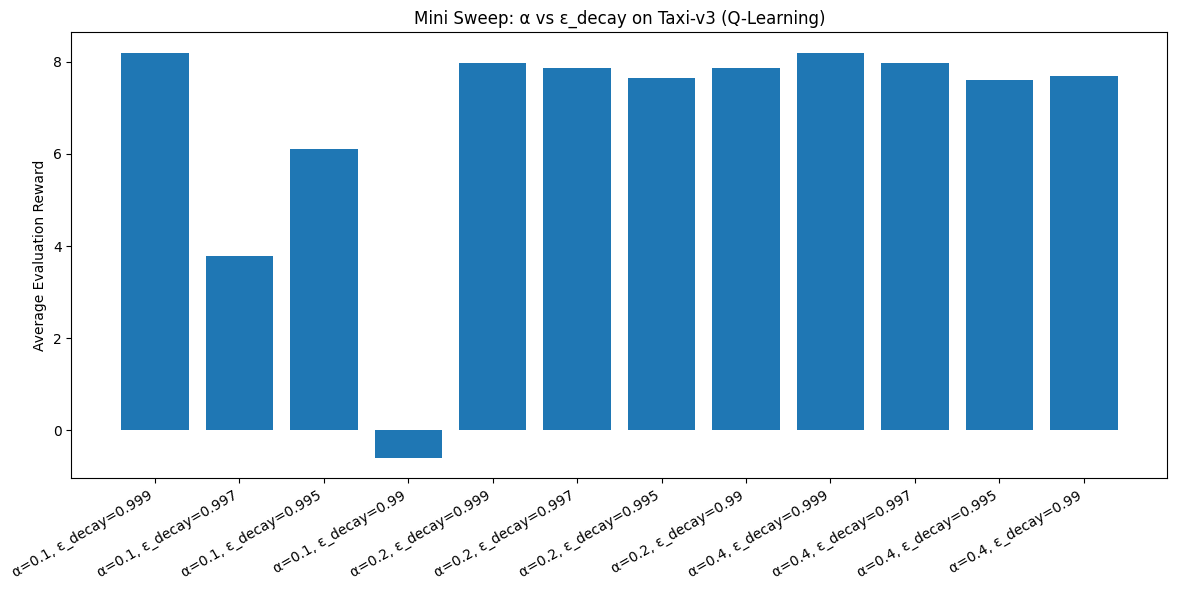

In [ ]:
# Mini Hyperparameter Sweep
# Compare a few values of epsilon_decay and alpha, report eval performance, and plot results.

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from itertools import product

def train_and_evaluate(alpha, epsilon_decay, episodes=3000, eval_episodes=100, seed=SEED):
    env = gym.make("Taxi-v3")
    env.reset(seed=seed)
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q_local = np.zeros((n_states, n_actions))

    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.05
    max_steps = 100

    # Training
    for ep in range(episodes):
        state, _ = env.reset()
        for _ in range(max_steps):
            # epsilon-greedy
            if np.random.rand() < epsilon:
                action = np.random.randint(n_actions)
            else:
                action = np.argmax(Q_local[state])
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Q-learning update
            best_next = np.argmax(Q_local[next_state])
            Q_local[state, action] += alpha * (reward + gamma * Q_local[next_state, best_next] - Q_local[state, action])

            state = next_state
            if terminated or truncated:
                break
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Evaluation (greedy)
    eval_rewards = []
    for _ in range(eval_episodes):
        state, _ = env.reset()
        total = 0
        for _ in range(max_steps):
            action = np.argmax(Q_local[state])
            state, reward, terminated, truncated, _ = env.step(action)
            total += reward
            if terminated or truncated:
                break
        eval_rewards.append(total)

    env.close()
    return float(np.mean(eval_rewards))

# Define small sweep space
alpha_values = [0.1, 0.2, 0.4]
epsilon_decay_values = [0.999, 0.997, 0.995, 0.99]

results = {}
for a, d in product(alpha_values, epsilon_decay_values):
    key = f"α={a}, ε_decay={d}"
    avg_r = train_and_evaluate(alpha=a, epsilon_decay=d, episodes=3000, eval_episodes=100, seed=SEED)
    results[key] = avg_r
    print(f"{key} -> Avg Eval Reward: {avg_r:.2f}")

# Plot results (bar chart)
labels = list(results.keys())
values = [results[k] for k in labels]

plt.figure(figsize=(12, 6))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
plt.ylabel("Average Evaluation Reward")
plt.title("Mini Sweep: α vs ε_decay on Taxi-v3 (Q-Learning)")
plt.tight_layout()
plt.show()
